<a href="https://colab.research.google.com/github/mvharsh/Deep-Learning/blob/main/RNN/RNN_Monthly_Milk_Production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#**Import Necessary Libraries:**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
from sklearn.metrics import mean_squared_error
import seaborn as sns


#**Load and Preprocess Data:**

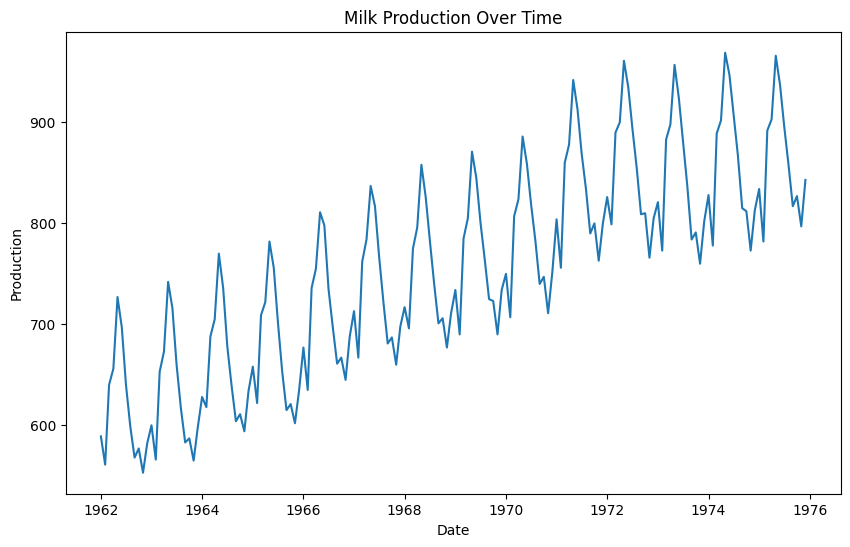

In [ ]:
# Load data
data = pd.read_csv("/content/drive/MyDrive/monthly_milk_production.csv")

# Convert date to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Plot the data
plt.figure(figsize=(10,6))
plt.plot(data['Date'], data['Production'])
plt.title('Milk Production Over Time')
plt.xlabel('Date')
plt.ylabel('Production')
plt.show()


Statistical Summary of the Data:
                                Date  Production
count                            168  168.000000
mean   1968-12-15 16:17:08.571428572  754.708333
min              1962-01-01 00:00:00  553.000000
25%              1965-06-23 12:00:00  677.750000
50%              1968-12-16 12:00:00  761.000000
75%              1972-06-08 12:00:00  824.500000
max              1975-12-01 00:00:00  969.000000
std                              NaN  102.204524


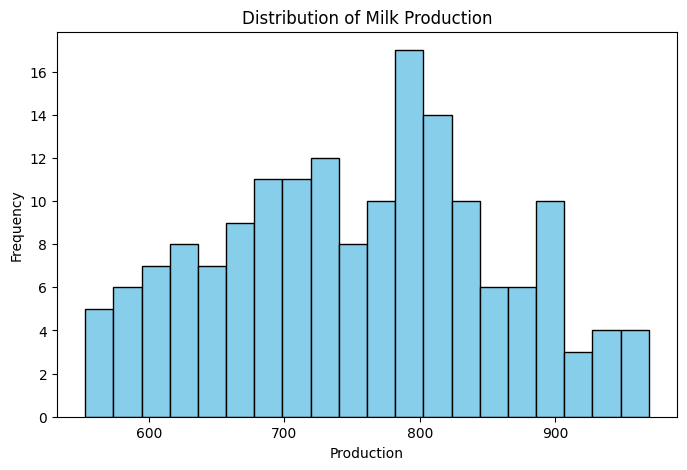

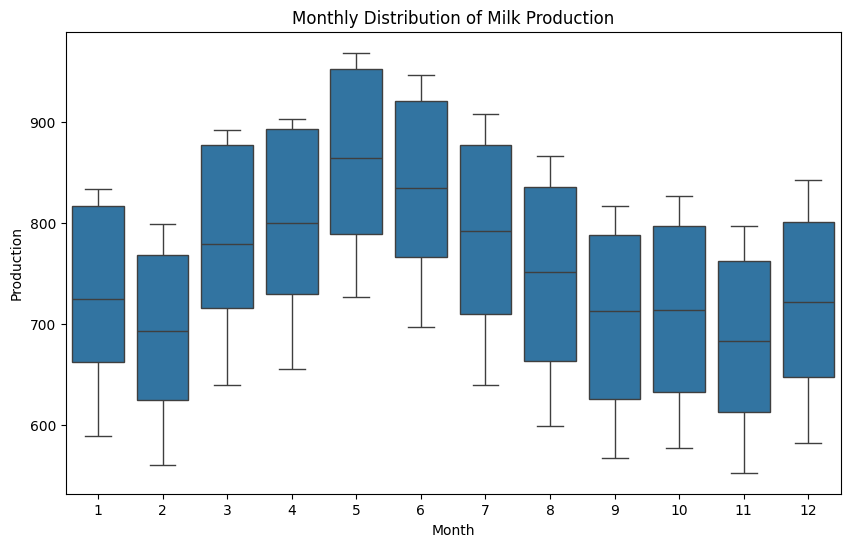

In [ ]:
# Statistical Summary
print("Statistical Summary of the Data:")
print(data.describe())

# Distribution of Production
plt.figure(figsize=(8, 5))
plt.hist(data['Production'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Milk Production')
plt.xlabel('Production')
plt.ylabel('Frequency')
plt.show()

# Boxplot of Production by Month
data['Month'] = data['Date'].dt.month
plt.figure(figsize=(10, 6))
sns.boxplot(x='Month', y='Production', data=data)
plt.title('Monthly Distribution of Milk Production')
plt.xlabel('Month')
plt.ylabel('Production')
plt.show()


In [ ]:
# Prepare data
scaler = MinMaxScaler()
data['Production'] = scaler.fit_transform(data['Production'].values.reshape(-1,1))

#**Create Training and Testing Data:**

In [ ]:
# Split data into train and test
train_size = int(len(data) * 0.8)
test_size = len(data) - train_size
train, test = data.iloc[0:train_size], data.iloc[train_size:len(data)]

# Function to create dataset
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 12

X_train, y_train = create_dataset(train[['Production']], train['Production'], time_steps)
X_test, y_test = create_dataset(test[['Production']], test['Production'], time_steps)


#**Build and Train RNN Model:**

In [ ]:
model = Sequential()
model.add(SimpleRNN(64, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_split=0.1, verbose=1, shuffle=False)


Epoch 1/100
7/7 [==============================] - 1s 45ms/step - loss: 0.0115 - val_loss: 0.0120
Epoch 2/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0196 - val_loss: 0.0183
Epoch 3/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0092 - val_loss: 0.0052
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0053 - val_loss: 0.0063
Epoch 5/100
7/7 [==============================] - 0s 8ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 6/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0027 - val_loss: 0.0049
Epoch 7/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 8/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0023 - val_loss: 0.0034
Epoch 9/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0021 - val_loss: 0.0030
Epoch 10/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 0.0030
Epoch 11/100
7/7 [==========

#**Evaluate the Model:**

In [ ]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])
test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train[0], train_predict[:,0]))
test_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')


1/1 [==============================] - 0s 27ms/step
Train RMSE: 14.784528252471508
Test RMSE: 12.971937400083974


In [ ]:
# Define a threshold (e.g., +/- 5% of the actual value)
threshold = 0.05

# Calculate the percentage of predictions within the threshold
train_accuracy = np.sum(np.abs(train_predict[:,0] - y_train[0]) / y_train[0] <= threshold) / len(y_train[0])
test_accuracy = np.sum(np.abs(test_predict[:,0] - y_test[0]) / y_test[0] <= threshold) / len(y_test[0])

print(f'Train Accuracy: {train_accuracy * 100:.2f}%')
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')


Train Accuracy: 97.54%
Test Accuracy: 100.00%


#**Visualize Predictions:**

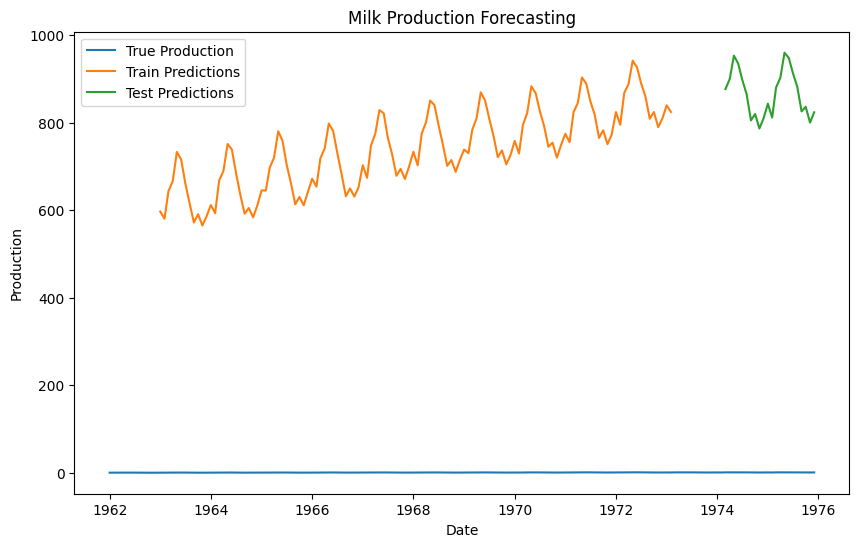

In [ ]:
plt.figure(figsize=(10,6))

plt.plot(data['Date'], data['Production'], label='True Production')
plt.plot(train['Date'].iloc[time_steps:], train_predict, label='Train Predictions')
plt.plot(test['Date'].iloc[time_steps:], test_predict, label='Test Predictions')

plt.title('Milk Production Forecasting')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.show()
